### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/AssoruleMining">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')
# Import other libraries required. All *.py will be 
# stored under the following location i.e. '/content/example.py'.
!git clone 'http://github.com/Nak007/AssoruleMining.git'
!pip install PrettyTable

## Example

In [1]:
import pandas as pd, numpy as np, sys, os
try: sys.path.append('/content/AssoruleMining')
except: pass
from AssoruleMining import *
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
X = pd.read_csv('C:\\Users\\Micky\\Desktop\\assoc_rules_data.txt', sep="|").drop(columns=["Uid","dataset"])

Remove `OAFM`, `VRM`, and `NOTI` rules.

In [3]:
columns, n_rows = X.columns[~X.columns.str.contains("|".join(["OAFM","VRM","NOTI"]))], len(X)
X = X[columns].copy()

Drop instances with no triggered rules.

In [4]:
X = X.loc[X.drop(columns=["f_fraud","month_id"]).sum(1)>0].reset_index(drop=True)
print("Remaining instances: {:,d} / {:,d}".format(len(X), n_rows))

Remaining instances: 640,069 / 910,351


Out-Of-Time periods.

In [5]:
oot_periods = ['2021-11', '2021-12', '2022-01', 
               '2022-02', '2022-03', '2022-04']

In [6]:
eval_set = dict()
for mth in np.unique(X["month_id"]):
    a = X.loc[X["month_id"]==mth,:].reset_index(drop=True).copy()
    b = a.pop("f_fraud").values
    eval_set[mth] = (a.drop(columns=["month_id"]),b)

In-Time periods.

In [7]:
periods = np.unique(X["month_id"])
periods = periods[~np.isin(periods, oot_periods)]
X0 = X.loc[X["month_id"].isin(periods),:].drop(columns=["month_id"]).reset_index(drop=True)
y0 = X0.pop("f_fraud").values

Split data into **train**, and **test** sets [(**`train_test_split`**)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [8]:
X_train, X_test, y_train, y_test = tts(X0, y0, test_size=0.3, shuffle=True, random_state=0)

## Validation of rules

Eliminate rule(s) with false alarms.

In [9]:
columns = X_train.columns[(((X_train + y_train.reshape(-1,1))==2).sum(0)==0)==False]
print("Remaining rules: {:,d} / {:,d}".format(len(columns), X_train.shape[1]))

Remaining rules: 86 / 126


<font color=blue size=4>**$1^{st}$ set of rules** </font>

In [10]:
X1 = X_train.loc[:,columns].copy()
y1 = y_train.copy()
rules1 = dict([(c,(c,"==",1)) for n,c in enumerate(X1.columns)])

In [11]:
asso1 = AssoRuleMining(metric="f1", operator="or", n_batches=5, n_jobs=4, max_features=10, min_support=50)
asso1.fit(X1, y1, rules=rules1)

**info** (attribute) : a summary table that comes in a form of `dict` with keys as column headers. It can be imported into a pandas DataFrame.

In [12]:
pd.DataFrame(asso1.info).sort_values(by=["recall","n_features"], 
                                     ascending=[False,True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
41,None,ECOM055.1,7,0.811519,0.410566,0.499635,0.811519,0.360924,0.576566
26,None,ECOM010.R,6,0.788384,0.277227,0.626144,0.788384,0.519281,0.494431
22,None,ECOM005,6,0.612626,0.196997,0.589391,0.612626,0.567853,0.539706
12,None,ECOM067.1,6,0.591453,0.171930,0.609252,0.591453,0.628156,0.525366
28,None,ECOM017.1,6,0.589180,0.156302,0.634898,0.589180,0.688308,0.505087


For this example, we focus on `recall`. Hence, we choose rule(s) that has the highest `recall` accordingly. In the case of a tie, we select `variable`, whose number of features is the lowest. This is for the sake of reducing rule complexity.

We use **`RuleToFeature`** to convert rules into features array.

In [13]:
rule1_index = "ECOM055.1"
FirstRule = RuleToFeature(X_train, asso1.asso_results_, which_rules=[rule1_index])

Use **`print_rule`** to tabulate rule information.

In [14]:
print_rule(FirstRule[1][rule1_index])

Operator:  or
+------+------------------------+------+-------+
| Item | Variable               | Sign | Value |
+------+------------------------+------+-------+
|  1   | ECOM055.1              |  ==  |  1.00 |
|  2   | ECOM017.1R             |  ==  |  1.00 |
|  3   | ECOM010.R              |  ==  |  1.00 |
|  4   | ECOM016.1              |  ==  |  1.00 |
|  5   | PGW0012.4_POS01_Reject |  ==  |  1.00 |
|  6   | ECOM014.2              |  ==  |  1.00 |
|  7   | EDC0098.1              |  ==  |  1.00 |
+------+------------------------+------+-------+


<font color=blue size=4>**$2^{nd}$ set of rules** </font>

Before determining next set of rules, we exclude instances as well as features that meet the $1^{st}$ rule.

In [15]:
index2 = FirstRule[0].values.ravel()
columns2 = set(columns).difference(asso1.asso_results_[rule1_index].features)
print("Remaining rules: {:,d} / {:,d}".format(len(columns2),X.shape[1]))
print("Remaining instances: {:,d} / {:,d}".format(sum(~index2),X_train.shape[0]))

Remaining rules: 79 / 128
Remaining instances: 166,178 / 281,928


In [16]:
X2 = X_train.loc[~index2, columns2].copy()
y2 = y_train[~index2].copy()
rules2 = dict([(c,(c,"==",1)) for n,c in enumerate(X2.columns)])

In [17]:
asso2 = AssoRuleMining(metric="f1", operator="or", n_batches=5, n_jobs=4, max_features=10, min_support=10)
asso2.fit(X2, y2, rules=rules2)

In [18]:
pd.DataFrame(asso2.info).sort_values(by=["recall","n_features"], 
                                     ascending=[False,True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
24,None,ECOM053.1,10,0.785015,0.508515,0.141519,0.785015,0.090138,0.306479
39,None,ECOM007.1,10,0.774194,0.542244,0.129082,0.774194,0.083366,0.310670
41,None,ECOM049.1,10,0.761002,0.513467,0.131711,0.761002,0.086538,0.309466
18,None,ECOM070.1,10,0.758116,0.468305,0.143319,0.758116,0.094523,0.305419
8,None,PGW0034.1,10,0.754921,0.455939,0.145968,0.754921,0.096678,0.304471


In [19]:
rule2_index = "ECOM053.1"
SecondRule = RuleToFeature(X_train, asso2.asso_results_, which_rules=[rule2_index])
print_rule(SecondRule[1][rule2_index])

Operator:  or
+------+-----------+------+-------+
| Item | Variable  | Sign | Value |
+------+-----------+------+-------+
|  1   | ECOM053.1 |  ==  |  1.00 |
|  2   | ECOM005   |  ==  |  1.00 |
|  3   | ECOM017.1 |  ==  |  1.00 |
|  4   | ECOM067.1 |  ==  |  1.00 |
|  5   | ECOM010.1 |  ==  |  1.00 |
|  6   | ECOM050.1 |  ==  |  1.00 |
|  7   | ECOM001.1 |  ==  |  1.00 |
|  8   | ECOM054.1 |  ==  |  1.00 |
|  9   | ECOM020.1 |  ==  |  1.00 |
|  10  | ECOM012.1 |  ==  |  1.00 |
+------+-----------+------+-------+


<font color=blue size=4>**$3^{rd}$ set of rules** </font>

In [20]:
index3 = FirstRule[0].values.ravel() | SecondRule[0].values.ravel() 
columns3 = set(columns2).difference(asso2.asso_results_[rule2_index].features)
print("Remaining rules: {:,d} / {:,d}".format(len(columns3),X.shape[1]))
print("Remaining instances: {:,d} / {:,d}".format(sum(~index3),X_train.shape[0]))

Remaining rules: 69 / 128
Remaining instances: 81,674 / 281,928


In [21]:
X3 = X_train.loc[~index3, columns3].copy()
y3 = y_train[~index3].copy()
rules3 = dict([(c,(c,"==",1)) for n,c in enumerate(X3.columns)])

In [22]:
asso3 = AssoRuleMining(metric="f1", operator="or", n_batches=5, n_jobs=4, max_features=10, min_support=1)
asso3.fit(X3, y3, rules=rules3)

In [23]:
pd.DataFrame(asso3.info).sort_values(by=["recall","n_features"], 
                                     ascending=[False,True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
52,None,ECOM049.1,10,0.641419,0.452763,0.046417,0.641419,0.036183,0.168793
49,None,ECOM011.1,10,0.569032,0.394838,0.041890,0.569032,0.036808,0.169176
50,None,ECOM007.1,10,0.567593,0.324987,0.050637,0.567593,0.044607,0.166813
11,None,EDC0101,10,0.557526,0.362441,0.043808,0.557526,0.039288,0.168538
30,None,EDC0102.1,10,0.554650,0.351091,0.044759,0.554650,0.040349,0.168253


In [24]:
rule3_index = "ECOM049.1"
ThirdRule = RuleToFeature(X_train, asso3.asso_results_, which_rules=[rule3_index])
print_rule(ThirdRule[1][rule3_index])

Operator:  or
+------+------------+------+-------+
| Item | Variable   | Sign | Value |
+------+------------+------+-------+
|  1   | ECOM049.1  |  ==  |  1.00 |
|  2   | ECOM007.1  |  ==  |  1.00 |
|  3   | ECOM070.1  |  ==  |  1.00 |
|  4   | PGW0034.1  |  ==  |  1.00 |
|  5   | ECOM027.1  |  ==  |  1.00 |
|  6   | ECOM071.1  |  ==  |  1.00 |
|  7   | ECOM017.2R |  ==  |  1.00 |
|  8   | EDC0092    |  ==  |  1.00 |
|  9   | ECOM018.1  |  ==  |  1.00 |
|  10  | ECOM026.1  |  ==  |  1.00 |
+------+------------+------+-------+


## Summary

Summary on `X_train`

In [25]:
y_pred_train = (FirstRule[0].values | SecondRule[0].values) | ThirdRule[0].values
print_stats(y_train, y_pred_train)

+----------------+---------+-------+
| Statistics     |   Value |     % |
+----------------+---------+-------+
| N              | 281,928 |       |
| Target         |  51,480 | 18.3% |
| True Positive  |  50,732 | 18.0% |
| True Negative  |  43,947 | 15.6% |
| False Positive | 186,501 | 66.2% |
| False Negative |     748 |  0.3% |
| Precision      |         | 21.4% |
| Recall         |         | 98.5% |
| Accuracy       |         | 33.6% |
| F1-Score       |         | 35.1% |
+----------------+---------+-------+


Summary on `X_test`

In [26]:
y_pred_test = (RuleToFeature(X_test, asso1.asso_results_, which_rules=[rule1_index])[0].values |
               RuleToFeature(X_test, asso2.asso_results_, which_rules=[rule2_index])[0].values | 
               RuleToFeature(X_test, asso3.asso_results_, which_rules=[rule3_index])[0].values)
print_stats(y_test, y_pred_test, 1)

+----------------+---------+-------+
| Statistics     |   Value |     % |
+----------------+---------+-------+
| N              | 120,827 |       |
| Target         |  21,960 | 18.2% |
| True Positive  |  21,618 | 17.9% |
| True Negative  |  18,562 | 15.4% |
| False Positive |  80,305 | 66.5% |
| False Negative |     342 |  0.3% |
| Precision      |         | 21.2% |
| Recall         |         | 98.4% |
| Accuracy       |         | 33.3% |
| F1-Score       |         | 34.9% |
+----------------+---------+-------+


In [27]:
tot_rules = np.r_[asso1.asso_results_[rule1_index].rule, 
                  asso2.asso_results_[rule2_index].rule, 
                  asso3.asso_results_[rule3_index].rule][:,0]
print("Number of rules: {:,d} / {:,d}".format(len(tot_rules),X0.shape[1]))
tot_rules

Number of rules: 27 / 126


array(['ECOM055.1', 'ECOM017.1R', 'ECOM010.R', 'ECOM016.1',
       'PGW0012.4_POS01_Reject', 'ECOM014.2', 'EDC0098.1', 'ECOM053.1',
       'ECOM005', 'ECOM017.1', 'ECOM067.1', 'ECOM010.1', 'ECOM050.1',
       'ECOM001.1', 'ECOM054.1', 'ECOM020.1', 'ECOM012.1', 'ECOM049.1',
       'ECOM007.1', 'ECOM070.1', 'PGW0034.1', 'ECOM027.1', 'ECOM071.1',
       'ECOM017.2R', 'EDC0092', 'ECOM018.1', 'ECOM026.1'], dtype='<U22')

Alternatively, we can use **`evaluate_rules`** to evaluate all datasets at the same time.

In [28]:
rules=[asso1.asso_results_[rule1_index], 
       asso2.asso_results_[rule2_index], 
       asso3.asso_results_[rule3_index]]
eval_asso = evaluate_rules(list(eval_set.values()), rules=rules, operator="or")

Existing rules.

In [29]:
subrules  = [(c,"==",1) for n,c in enumerate(X0.columns)]
ext_rules = create_rule(subrules, operator="or")
eval_exst = evaluate_rules(list(eval_set.values()), rules=[ext_rules])

## Visualization

In [30]:
x = np.arange(len(eval_set))
xticklabels = list(eval_set.keys())
n_rules = (X0.shape[1], len(tot_rules))

In [31]:
def plot_results(x, y1, y2, ylabel, xticklabels, n_rules):
    before, after = n_rules
    ax = plt.subplots(figsize=(12, 4.3))[1]
    ax.plot(x, y1, lw=3.5, c="#05c46b", marker="o", ms=8,
            label="{:,d} rules (ARM)".format(after))
    ax.plot(x, y2, ls="--", c="grey",
            label="{:,d} rules (Existing)".format(before))
    set_prop(ax, x, ylabel, xticklabels)
    plt.tight_layout()
    return ax

In [32]:
def plot_differnce(x, y, ylabel, xticklabels):
    ax = plt.subplots(figsize=(12, 4.3))[1]
    ax.plot(x, y, lw=3.5, c="#05c46b", marker="o", 
            ms=8, label="Difference")
    set_prop(ax, x, ylabel, xticklabels)
    plt.tight_layout()
    return ax

In [33]:
def set_prop(ax, x, ylabel, xticklabels):
    '''set other ax properties'''
    for s in ["top","right"]: ax.spines[s].set_visible(False)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min, y_max+(y_max-y_min)*0.1)
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, fontsize=12, rotation=45)
    ax.set_xlim(-0.5,len(x)-0.5)
    ax.set_xlabel("Period", fontsize=13, fontweight=600)
    ax.set_ylabel(ylabel, fontsize=13, fontweight=600)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(8))
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)
    ax.tick_params(axis='both', labelsize=12)
    ax.axvspan(-1, 22, color="#c8d6e5", hatch="///", zorder=-1,
               alpha=0.4, label="In-Time (22)")
    ax.axvspan(22, 30, color="#10ac84", zorder=-1,
               alpha=0.2, label="Out-Of-Time (6)")
    legend = ax.legend(loc="upper left", fontsize=12) 
    legend.set_bbox_to_anchor([1,1], transform=ax.transAxes)
    return ax

- Precision

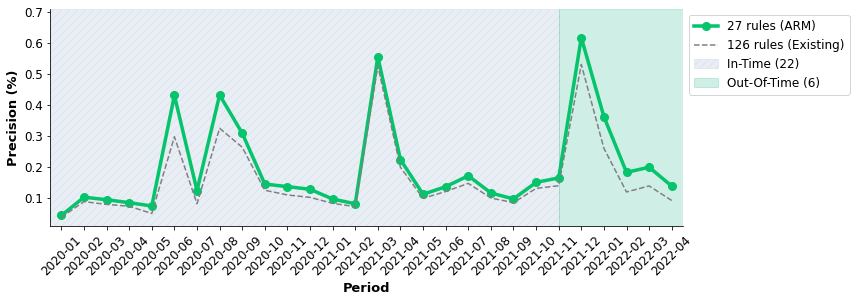

In [34]:
ax = plot_results(x, eval_asso.precision, eval_exst.precision, 
                  "Precision (%)", xticklabels, n_rules)

- Recall

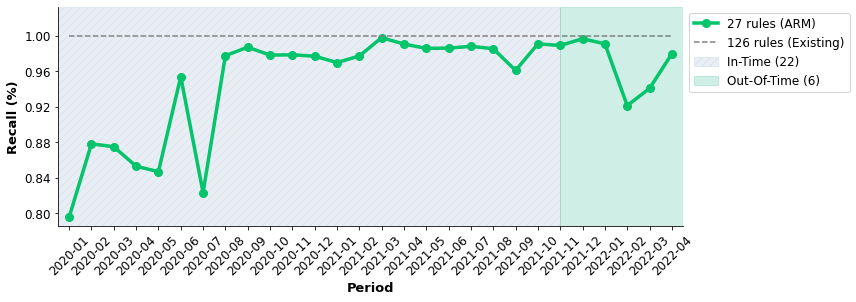

In [35]:
ax = plot_results(x, eval_asso.recall, eval_exst.recall, 
                  "Recall (%)", xticklabels, n_rules)

- Number of False-Positive transactions

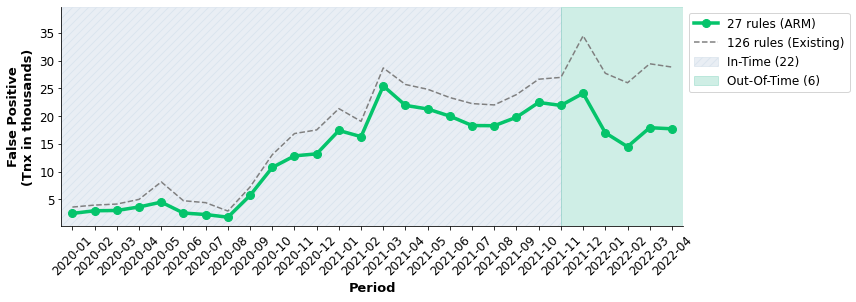

In [36]:
ax = plot_results(x, np.r_[eval_asso.fp]/1000, np.r_[eval_exst.fp]/1000, 
                  "False Positive\n(Tnx in thousands)", xticklabels, n_rules)

- Number of alerts

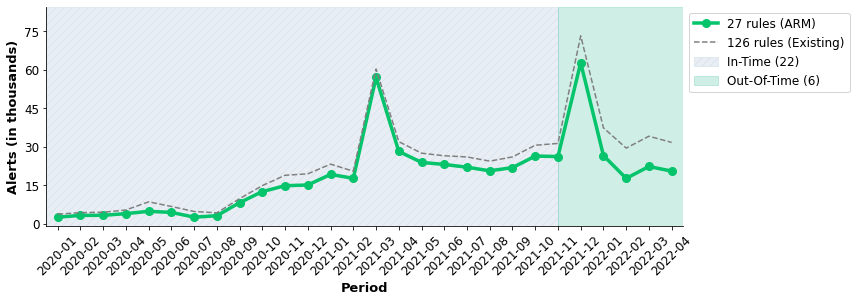

In [37]:
a = (np.r_[eval_asso.tp] + np.r_[eval_asso.fp])
b = (np.r_[eval_exst.tp] + np.r_[eval_exst.fp])
ax = plot_results(x, a/1000, b/1000, "Alerts (in thousands)", xticklabels, n_rules)

- Number of differece in alerts

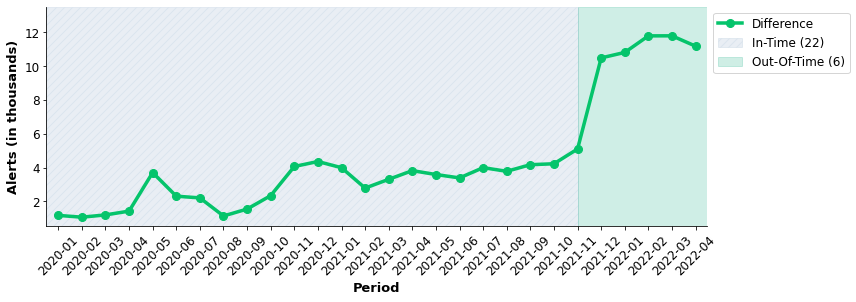

In [38]:
ax = plot_differnce(x, (b-a)/1000, "Alerts (in thousands)", xticklabels)

## Fixing the drop in recall 
- From 2022-01 until 2022-02

In [39]:
oot_cols = ["f_fraud"] + list(set(list(X_train)).difference(tot_rules))
oot_X = X.loc[X["month_id"].isin(["2022-02","2022-03"]), oot_cols].reset_index(drop=True)
oot_y = oot_X.pop("f_fraud").values
oot_rules = dict([(c,(c,"==",1)) for n,c in enumerate(oot_X.columns)])

In [40]:
asso4 = AssoRuleMining(metric="recall", operator="or", n_batches=5, n_jobs=4, max_features=10, min_support=1)
asso4.fit(oot_X, oot_y, rules=oot_rules)

In [41]:
pd.DataFrame(asso4.info).sort_values(by=["recall", "n_features"], ascending=[False,True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
2,None,ECOM077.1,10,0.120435,0.297630,0.012541,0.120435,0.052067,0.535259
12,None,ECOM024.1,10,0.120435,0.295885,0.012615,0.120435,0.052374,0.535565
14,None,ECOM028.1,10,0.120435,0.296954,0.012570,0.120435,0.052186,0.535378
3,None,ECOM048.1_1,10,0.120191,0.306180,0.012142,0.120191,0.050511,0.533668
19,None,ECOM046.1,10,0.120191,0.296168,0.012552,0.120191,0.052218,0.535459


In [42]:
rule4_index = "ECOM077.1"
FourthRule = RuleToFeature(X_train, asso4.asso_results_, which_rules=[rule4_index])
print_rule(FourthRule[1][rule4_index])

Operator:  or
+------+-----------------+------+-------+
| Item | Variable        | Sign | Value |
+------+-----------------+------+-------+
|  1   | ECOM077.1       |  ==  |  1.00 |
|  2   | ML002           |  ==  |  1.00 |
|  3   | ECOM074.1       |  ==  |  1.00 |
|  4   | ECOM048.1_2     |  ==  |  1.00 |
|  5   | ECOM073.1       |  ==  |  1.00 |
|  6   | ECOM023.1       |  ==  |  1.00 |
|  7   | PGW0012.4_POS01 |  ==  |  1.00 |
|  8   | ECOM051.1       |  ==  |  1.00 |
|  9   | ML001           |  ==  |  1.00 |
|  10  | ECOM065.1       |  ==  |  1.00 |
+------+-----------------+------+-------+


In [43]:
rules=[asso1.asso_results_[rule1_index], 
       asso2.asso_results_[rule2_index], 
       asso3.asso_results_[rule3_index],
       asso4.asso_results_[rule4_index]]
eval_asso = evaluate_rules(list(eval_set.values()), rules=rules, operator="or")

In [44]:
n_rules = (X0.shape[1], len(tot_rules) + len(FourthRule[1][rule4_index].rule))

- Recall

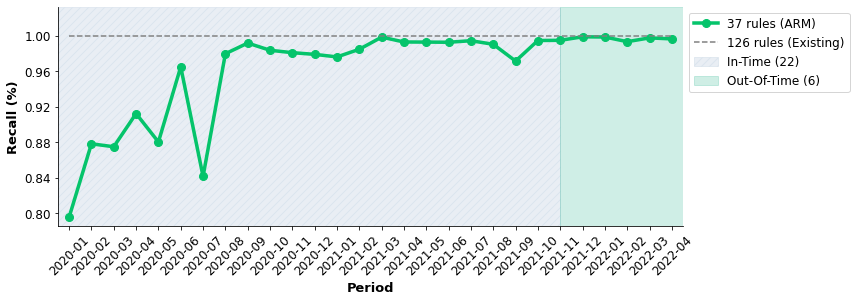

In [45]:
ax = plot_results(x, eval_asso.recall, eval_exst.recall, 
                  "Recall (%)", xticklabels, n_rules)

- Precision

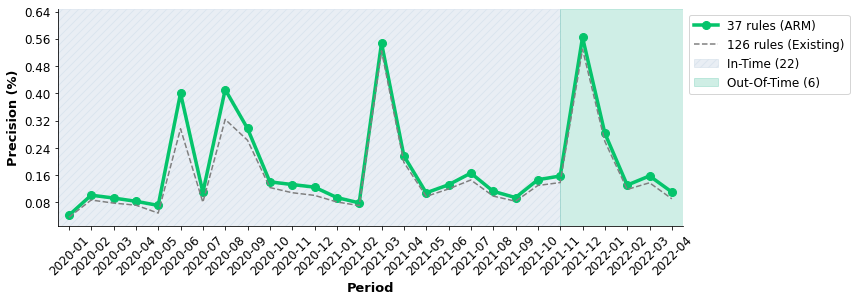

In [46]:
ax = plot_results(x, eval_asso.precision, eval_exst.precision, 
                  "Precision (%)", xticklabels, n_rules)

- Number of False-Positive transactions

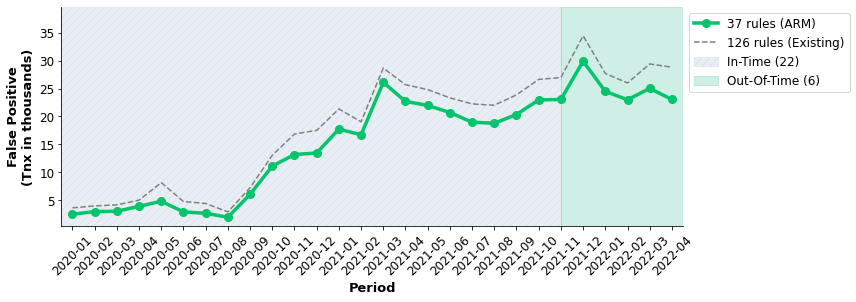

In [47]:
ax = plot_results(x, np.r_[eval_asso.fp]/1000, np.r_[eval_exst.fp]/1000, 
                  "False Positive\n(Tnx in thousands)", xticklabels, n_rules)

- Number of alerts

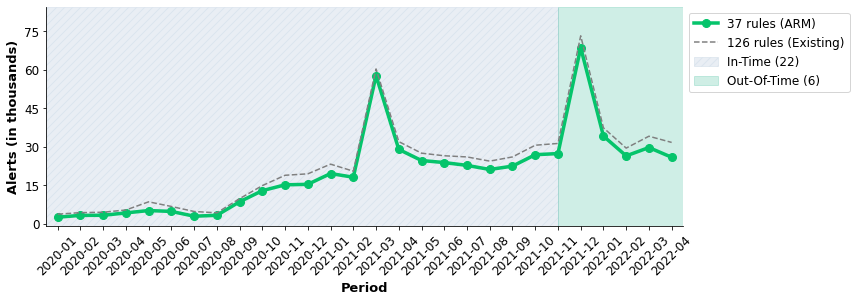

In [48]:
a = (np.r_[eval_asso.tp] + np.r_[eval_asso.fp])
b = (np.r_[eval_exst.tp] + np.r_[eval_exst.fp])
ax = plot_results(x, a/1000, b/1000, "Alerts (in thousands)", xticklabels, n_rules)

- Number of differece in alerts

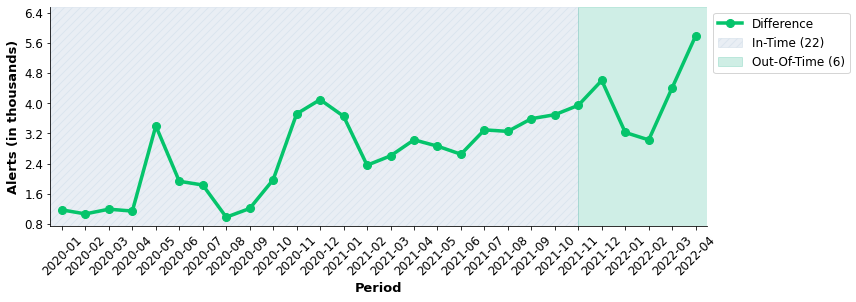

In [49]:
ax = plot_differnce(x, (b-a)/1000, "Alerts (in thousands)", xticklabels)

## Final set of rules

In [51]:
final_rules = [c[0] for n in range(len(rules)) for c in rules[n].rule]
# final_rules